[49.0, 48.0]
1.0
('HG00171', 'CLR', 'vqv')
[50.0, 49.0]
1.0
('HG00732', 'CLR', 'vqv')
[49.0, 48.0]
1.0
('HG00864', 'CLR', 'vqv')
[50.0, 51.0]
1.0
('HG02492', 'CLR', 'vqv')
[46.0, 45.0]
1.0
('HG02587', 'CLR', 'vqv')
[49.0, 50.0]
1.0
('HG03065', 'CLR', 'vqv')
[46.0, 47.0]
1.0
('HG03732', 'CLR', 'vqv')
[51.0, 50.0]
1.0
('NA12329', 'CLR', 'vqv')
[49.0, 50.0]
1.0
('NA18939', 'CLR', 'vqv')
[50.0, 51.0]
1.0
('NA19983', 'CLR', 'vqv')
[54.0, 55.0]
1.0
('NA19240', 'HiFi', 'vqv')


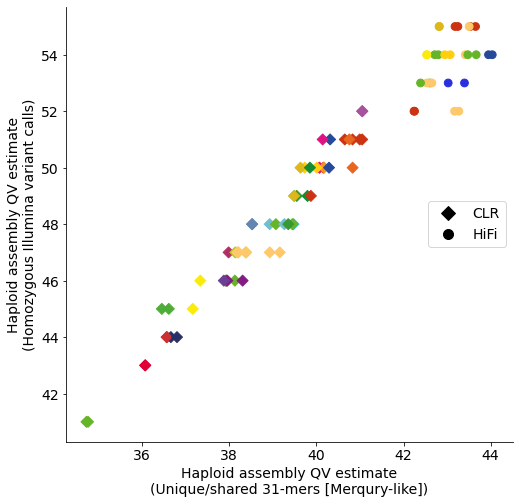

In [1]:
import os
import collections as col
import importlib
import operator
import math

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines

plot_aux_module = '/home/local/work/code/github/project-diploid-assembly/notebooks/aux_mods/plot_aux.py'
plot_aux_spec = importlib.util.spec_from_file_location("plot_aux", plot_aux_module)
plot_aux = importlib.util.module_from_spec(plot_aux_spec)
plot_aux_spec.loader.exec_module(plot_aux)

samples = plot_aux.load_sample_table()
hexcodes, rgbcodes, popmap = plot_aux.load_population_annotation()

prop = plot_aux.get_plot_property

pipeline_version = 'v12'

stats_path = '/home/local/work/data/hgsvc/fig1_panels/qv_estimates'
out_path = os.path.join(stats_path, pipeline_version, 'fig1_panel_qv-estimates')
cache_file = os.path.join(stats_path, 'cache_{}.h5'.format(pipeline_version))


def prob_base_correct(kmer_shared, kmer_total, kmer_size=31):
    
    return (kmer_shared / kmer_total) ** (1/kmer_size)


def base_error_rate(kmer_assembly_only, kmer_total, kmer_size=31):
       
    return 1 - (1 - kmer_assembly_only / kmer_total) ** (1/kmer_size)


def qv_estimate(error_rate):
    
    return -10 * math.log10(error_rate)


def load_qv_estimates(file_path):
    sample_stats = dict()
    with open(file_path, 'r') as table:
        for line in table:
            key, value = line.strip().split()
            if key.endswith('pct'):
                sample_stats[key] = float(value)
            else:
                sample_stats[key] = int(value)
    return sample_stats


def extract_assembly_type(file_name):
    assmt = None
    if '_nhr-' in file_name:
        assmt = 'NHR', 0
    elif 'h1-un' in file_name:
        assmt = 'HAP', 1
    elif 'h2-un' in file_name:
        assmt = 'HAP', 2
    else:
        raise ValueError('ASSMT: {}'.format(file_name))
    if assmt is None:
        raise ValueError('ASSMT: {}'.format(file_name))
    return assmt


if not os.path.isfile(cache_file):
    stat_files = plot_aux.load_plot_data_files(
        stats_path,
        '.qv.tsv',
        pipeline_version)
    plot_data = [load_qv_estimates(fp) for fp in stat_files]

    sample_platform = [
        plot_aux.extract_sample_platform(
            os.path.basename(f),
            mapped_readset=True
        ) for f in stat_files
    ]
    
    haplotypes = [
        extract_assembly_type(
            os.path.basename(f),
        ) for f in stat_files
    ]

    row_index = []
    for (sample, platform), (_, hap) in zip(sample_platform, haplotypes):
        super_pop = samples[sample]['super_population']
        pop = samples[sample]['population']
        row_index.append((sample, super_pop, pop, platform, 'HAP', hap))

    df = pd.DataFrame(
        plot_data,
        columns=sorted(plot_data[0].keys()),
        index=row_index
    )

    df.index = pd.MultiIndex.from_tuples(
        df.index.values,
        names=['sample', 'super_pop', 'pop', 'platform', 'assembly', 'hap']
    )
    df.to_hdf(cache_file, key='cache', mode='w', format='fixed')
    
df = pd.read_hdf(cache_file, 'cache')
df.sort_index(axis=0, inplace=True, level=['sample', 'super_pop', 'pop', 'platform', 'assembly', 'hap'])

kmer_cache = '/home/local/work/data/hgsvc/fig1_panels/kmer_stats/cache_{}.h5'.format(pipeline_version)
if not os.path.isfile(kmer_cache):
    raise ValueError('Need k-mer cache for Merqury-style QV estimate')

kmer_data = pd.read_hdf(kmer_cache, 'cache')
kmer_data.sort_index(axis=0, inplace=True, level=['sample', 'super_pop', 'pop', 'platform', 'assembly', 'hap'])
    
errors, missing = plot_aux.check_cache_consistency(df)
if errors:
    raise ValueErrors('Skip sample(s) in cache: {}'.format(errors))
if missing:
    print(sorted(missing))
    print('---------------')
    
    
def plot_kmer_stats(sample_stats, kmer_stats):
    
    fig, axis = plt.subplots(figsize=(8,8))
    
    qv_collect = col.defaultdict(list)
    
    for platform in plot_aux.get_sequencing_platforms():
        for hap in [1, 2]:
            subset = sample_stats.xs((platform, hap) , level=('platform', 'hap'), drop_level=False)
            get_assembly_kmers = operator.itemgetter(
                *(
                    'Hap{}_only'.format(hap),
                    'Hap_only'
                )
            )
            get_remaining_kmers = operator.itemgetter(
                *(
                    'Illumina_only',
                    'Hap{}_Illumina'.format(hap),
                    'Hap_Illumina',
                    'Hap{}_GRCh38'.format(hap),
                    'Hap_GRCh38',
                    'GRCh38_Illumina',
                    'GRCh38_shared'
                )
            )
            
            x_values = []
            y_values = []
            colors = []
            labels = []
            
            for idx, row in subset.iterrows():
                variant_qv = row['QV_all_hom_highconf|unlifted']
                
                kmer_idx = idx[0], idx[1], idx[2], idx[3], idx[4], 0
                kmer_data = kmer_stats.loc[kmer_idx, :]
                assert kmer_data.shape == (13,), 'Ambig. kmer stats: {}'.format(kmer_data)
                
                kmer_assm_count = sum(get_assembly_kmers(kmer_data))
                kmer_remain_count = sum(get_remaining_kmers(kmer_data))
                kmer_total_count = kmer_assm_count + kmer_remain_count
                error_rate = base_error_rate(kmer_assm_count, kmer_total_count, kmer_size=31)
                merqury_qv = qv_estimate(error_rate)
                
                label = idx[0] + '-{}-Hap{}'.format(platform, hap)
                qv_collect[(idx[0], platform, 'mqv')].append(merqury_qv)
                qv_collect[(idx[0], platform, 'vqv')].append(variant_qv)
                                
                x_values.append(merqury_qv)
                y_values.append(variant_qv)
                colors.append(rgbcodes[idx[2]])
                labels.append(label)
            
            axis.scatter(
                x_values,
                y_values,
                s=prop('plot_marker_size'),
                c=colors,
                marker=prop('{}_marker'.format(platform)),
                label=labels
            )

    axis.set_xlabel(
        'Haploid assembly QV estimate\n(Unique/shared 31-mers [Merqury-like])',
        fontsize=prop('fontsize_legend')
    )
    axis.set_ylabel(
        'Haploid assembly QV estimate\n(Homozygous Illumina variant calls)',
        fontsize=prop('fontsize_legend')
    )
    
    axis.tick_params(
        axis='both',
        which='major',
        labelsize=prop('fontsize_axis_ticks')
    )
    
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    
    # build custom legend
    custom_lines = [
        lines.Line2D(
            [0], [0],
            color='black',
            markersize=prop('legend_marker_size'),
            marker=prop('CLR_marker'),
            ls='None',
            label='CLR'
        ),
        lines.Line2D(
            [0], [0],
            color='black',
            markersize=prop('legend_marker_size'),
            marker=prop('HiFi_marker'),
            ls='None',
            label='HiFi'
        )   
    ]
    
    axis.legend(
        handles=custom_lines,
        loc='center right',
        prop={'size': prop('fontsize_legend')}
    )

    if missing:
        plot_aux.add_incomplete_stamp(axis, 0.2, 0.6)
    
    for sample, qv_est in qv_collect.items():
        diff = max(qv_est) - min(qv_est)
        if diff >= 1:
            print(qv_est)
            print(diff)
            print(sample)
    
    extra_artists = []

    return fig, extra_artists
        
fig, exart = plot_kmer_stats(df, kmer_data)
    
fig.savefig(out_path + '.png', dpi=600, bbox_inches='tight', extra_artists=exart)
fig.savefig(out_path + '.svg', bbox_inches='tight', extra_artists=exart)
        
